In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import pylops
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy

In [3]:
from pygsp import graphs, filters, plotting, utils

### Total variation of eigenvectors

In [4]:
# Create a random directed graph
G = nx.gnp_random_graph(100, 0.5, directed=True)
A = nx.to_numpy_array(G)

In [5]:
# Reproducing Fig 2 in the magnetic Laplacian paper - (i.e. do we have an intuitive notion of frequency)

In [6]:
def total_variation(f, G):
    source, target, _ = G.get_edge_list()
    TV = 0
    for (s, t) in zip(source, target):
        TV += np.abs(f[s] - f[t])**2
    return TV

In [7]:
# Symmetrize, unweighted A laplacian, just for reference
Asym = 1/2 * (A + A.T)
Adj = 1 * Asym != 0
gref = graphs.Graph(Adj)

(4.910482994312255e-14+0j)


/Users/yao/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.09595350305991177+6.223454645001465e-16j)
(2.378748125427454+2.44743223993632e-15j)
(9.265818067679579-1.3825204408994952e-15j)
(47.07239544159344+4.475178844105586e-15j)
(54.80742299413491-2.3350232282050413e-29j)


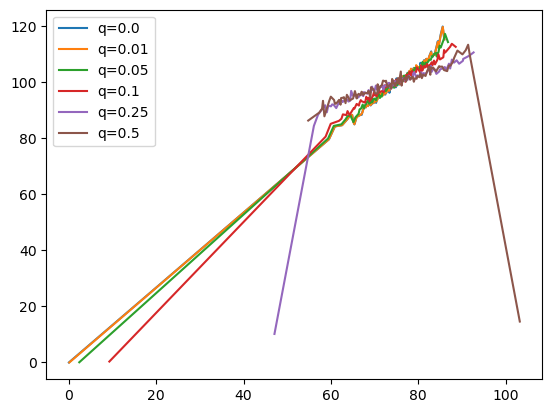

In [8]:
for q_ in np.array([0, 0.01, 0.05, 0.1 , 0.25, 0.5]):
    A = 1 * (A != 0)
    g = graphs.DiGraph(A, q=q_)
    eig, U = np.linalg.eig(g.L)
    print(np.min(eig))
    eig_order = np.argsort(eig)[::-1]
    eig = eig[eig_order]
    U = U[:, eig_order]

    TV = np.zeros(U.shape[1])
    for i in range(U.shape[1]):
        TV[i] = total_variation(U[:, i], g)

    plt.plot(eig, TV, label='q={}'.format(q_))

plt.legend()

### Wavelet visualization

2023-09-02 01:08:39,403:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


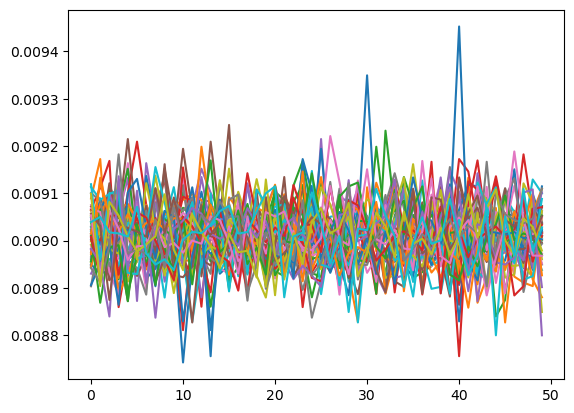

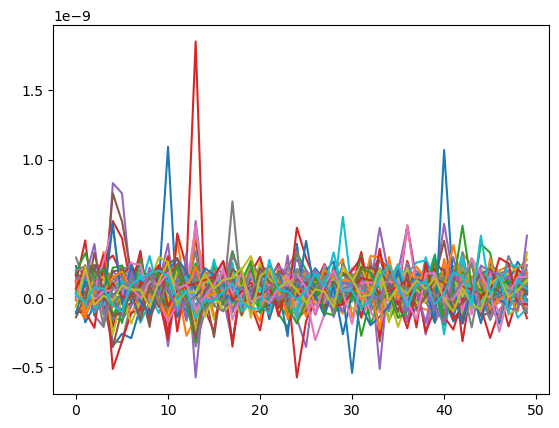

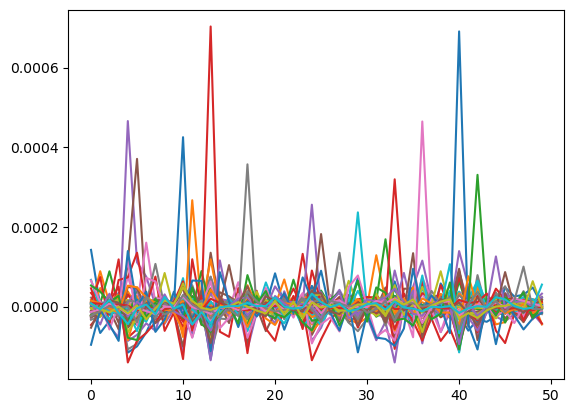

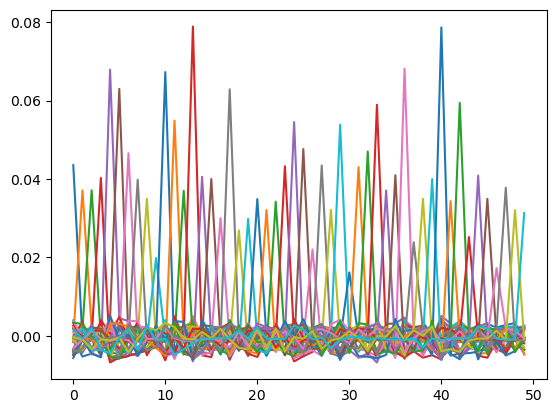

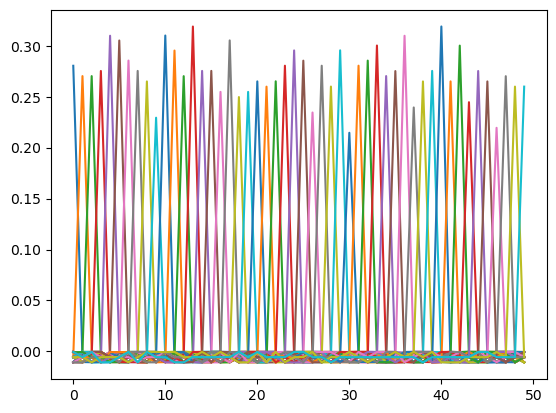

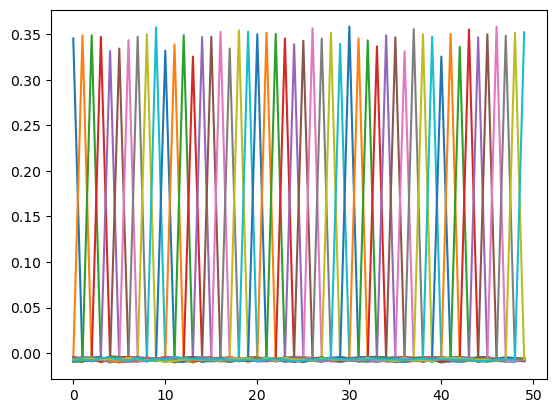

In [750]:
G = nx.gnp_random_graph(50, 0.5, directed=True)
A = nx.to_numpy_array(G)
# Choose q_ = 0.05
q_ = 0.05
#g = graphs.DiGraph(A,q=q_)
g = graphs.Graph(A)
# Assemble a cubic spline filter bank on the graph
fs = filters.MexicanHat(g, 6)
W = fs.compute_frame()
for i in range(6):#W.shape[0]
    for j in range(50*i,50*(i+1)):
    #nx.draw(G, node_color=W[i], with_labels=True, cmap='viridis')
    #plt.show()
        plt.plot(W[j])
    plt.show()
    

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MexicanHat(in=1, out=6, lpfactor=20.00, normalize=False)'}, xlabel="laplacian's eigenvalues (graph frequencies) $\\lambda$", ylabel='filter response $g(\\lambda)$'>)

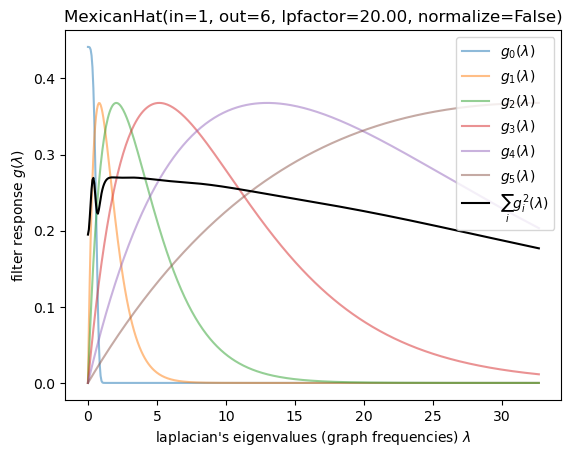

In [751]:
fs.plot()

In [94]:
# Initialize a random signal over the graph and calculate the reconstruction coefficients
sig = np.random.randn(fs.G.N)

In [96]:
W = fs.compute_frame()
def project_signal2(sig, W):
    beta = np.zeros(W.shape[0])
    for i in range(W.shape[0]):
            beta[i] = W[i, :] @ sig

    return beta 
coeff = project_signal2(sig, W)
# is the (wavelet) coeff being calculated corretly?
print(fs.estimate_frame_bounds())
np.linalg.norm(coeff)**2/np.linalg.norm(sig)**2

In [98]:
s = fs.localize(1, method='exact')
#so this "localize" object is basially all the wavelets on that node
g.set_coordinates()
g.plot(np.real(s[:,1]))

2023-08-28 18:06:10,138:[WARNING](pygsp.graphs.graph._check_fourier_properties): The eigenvalues vector G.e is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


(50, 6)

In [ ]:
# One approach: one can use polynomial filters, as these will be necessary localized in the vertex domain.

### Sparse coding Graph Signal

In [7]:
def grad_logdet_P(A, B):
    # gradient logdet of the solution of continuous lyapunov equation
    # note: lyapunov equation is a special case of the sylvester equation
    # A will be orginal graph (not the line graph)
    # tol = np.finfo(float).eps    

    N = A.shape[0]
    #B = np.ones((N,1))    
    P = scipy.linalg.solve_lyapunov(A, -B@B.T)
    if np.linalg.matrix_rank(P) == N:
        P_adjoint = np.linalg.inv(P).T
    else:
        P_adjoint = np.linalg.pinv(P).T
        print("Gramian rank: ", np.linalg.matrix_rank(P))
        print("Gramin adjoint min & max: ", np.min(P_adjoint),np.max(P_adjoint))
    
    
    S = scipy.linalg.solve_sylvester(A.T, A, -P_adjoint) #sylvester equation: AX+XB=Q
    
    grad_logdet_P = S@P.T
    return grad_logdet_P

def project_signal2(sig, W):
    beta = np.zeros(W.shape[0],dtype="complex128")
    #print(W.dtype, sig.dtype)
    for i in range(W.shape[0]):
        
        beta[i] = np.conjugate(W[i, :]) @ sig

    return beta 

def fista_coeff(G, B, eps,tol, directed = False):
    #G is the original graph
    # B is the input node indicator vector
    
    A = nx.to_numpy_array(G)

    G_line = nx.line_graph(G)
    A_line = nx.to_numpy_array(G_line)
    if directed:
        g = graphs.DiGraph(A_line, q = 0.05)
    else:
        g = graphs.Graph(A_line)

    # Assemble a cubic spline filter bank on the graph
    fs = filters.Abspline(g, 6)
    #print("Node count in line graph: ", fs.G.N)


    #computing graph signal
    sig_line = np.zeros(A_line.shape[0])
    gs = grad_logdet_P(A, B)
    for i,n in enumerate(G_line.nodes()):
        sig_line[i] = gs[n[0],n[1]]

    #checking frame bound
    if directed:
        W = fs.compute_frame(method = "exact")
    else:
        W = fs.compute_frame()
    
    coeff = project_signal2(sig_line, W)

    fb = fs.estimate_frame_bounds()
    assert(fb[0]<np.linalg.norm(coeff)**2/np.linalg.norm(sig_line)**2<fb[1])

    W_op = pylops.LinearOperator(aslinearoperator(W.T))
    xfista, niterf, costf = pylops.optimization.sparsity.fista(
        W_op,
        sig_line,
        niter=50,
        eps=eps,
        tol=tol,
    )
    
    return xfista, W, sig_line

def draw_partial_reconstruction(G, G_line, num_wavelet, xfista):   
    G_wavelet = deepcopy(G)
    print("Num of nonzero coeff: ", np.count_nonzero(xfista))
    s=0

    weighted_wavelet_combo = np.zeros(n_edge)
    for i in np.nonzero(xfista)[0][s:s+num_wavelet]:
        weighted_wavelet_combo += xfista[i]*W[i]

    attrs = {}
    for j,e in enumerate(G_line.nodes()):
        attrs[e]={"wavelet comp": weighted_wavelet_combo[j]}   
    nx.set_edge_attributes(G_wavelet, attrs)

    comp = nx.get_edge_attributes(G_wavelet,"wavelet comp").values()
    nx.draw(G_wavelet,  width=np.sqrt(np.abs(list(comp))))
    plt.show()
    
    
def plot_reconstructed_signal(xfista, W, sig_line):
    sort_idx = np.argsort(sig_line)


    #plt.plot((W1.T@xista)[sort_idx],alpha=0.5,label="ISTA coeff reconstruction")
    plt.plot((np.conjugate(W.T)@xfista)[sort_idx],alpha=0.5,label="FISTA coeff reconstruction")
    #plt.plot((W1.T@xomp)[sort_idx],alpha=0.5,label="OMP coeff reconstruction")
    plt.plot(sig_line[sort_idx],"k--",alpha=0.2,label="original graph signal")
    plt.legend()
    plt.xlabel("Edge index")
    plt.ylabel("Signal: " + r"$\frac{\partial(logdet(P))}{\partial A}$")
    plt.show()
    
    #plt.plot(np.abs((W1.T@xista-sig_line)/sig_line)[sort_idx], alpha = 0.5, label="ISTA")
    plt.plot(np.abs(((np.conjugate(W.T)@xfista)[sort_idx]-sig_line)/sig_line)[sort_idx], alpha = 0.5, label="FISTA")
    #plt.plot(np.abs((W1.T@xomp-sig_line)/sig_line)[sort_idx], alpha = 0.5, label="OMP")
    plt.yscale("log")
    plt.xlabel("Edge index")
    plt.title("Fractional error of sparse reconstructed signal")
    plt.legend()
    plt.show()

In [8]:
N = 50  #number of nodes
G = nx.gnp_random_graph(N, 0.5, directed=False)
G_line = nx.line_graph(G)
n_edge = len(G.edges())

#nx.draw(G,with_labels = True)

In [19]:
eps = 0.5
tol = 1e-8
B = np.ones((N,1))
num_wavelet = 10

#B = np.zeros((N,1))
#input_idx = np.random.choice(N,int(N/10*(i+1)),replace = False)
#for c in input_idx:
    #B[c] = 1

xfista, W, sig_line = fista_coeff(G,B,eps,tol,directed = False)
frac_err = np.abs((W.T@xfista-sig_line)/sig_line)
print(min(frac_err),np.mean(frac_err),max(frac_err))

2023-09-05 09:33:51,937:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


1.409660122127604e-05 0.1493949603921739 5.899243405361363


In [20]:
np.count_nonzero(np.real(xfista))

671

Num of nonzero coeff:  671


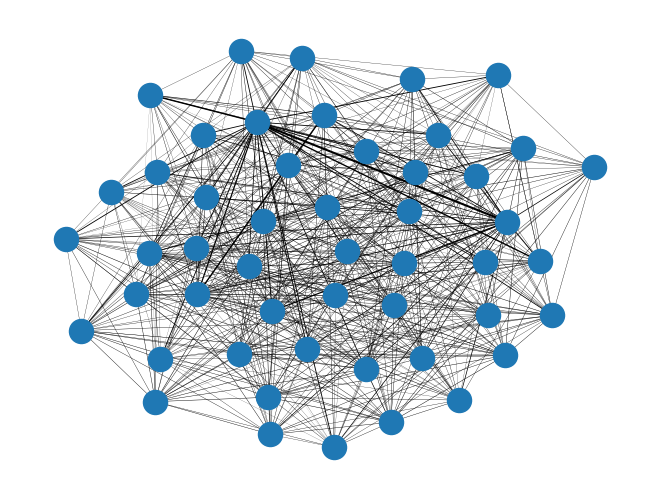

In [21]:
draw_partial_reconstruction(G, G_line, num_wavelet, xfista)

In [22]:
#np.conjugate(W.T)@xfista
#sig_line

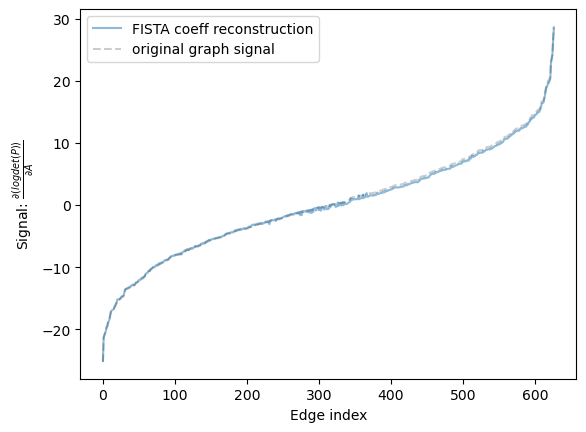

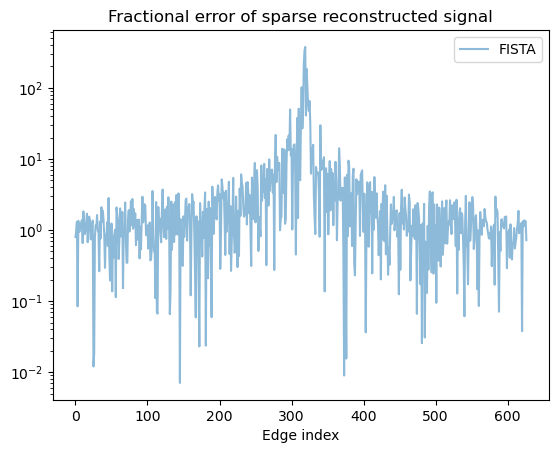

In [23]:
plot_reconstructed_signal(xfista, W, sig_line)

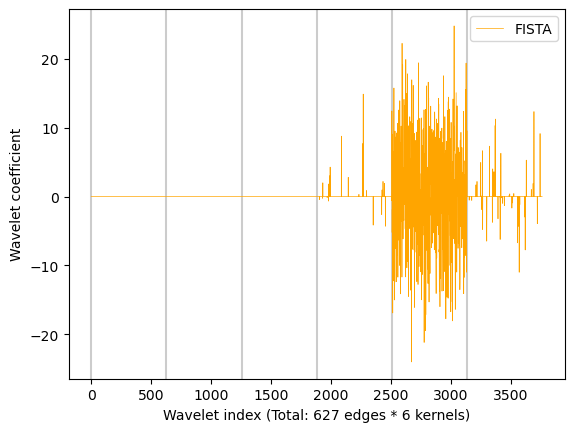

In [24]:

text_box_y = -900
for i in range(6):
    #plt.text(fs.G.N*(i+0.02), text_box_y, 'kernel '+str(i+1), style='italic',
        #bbox={'alpha': 0.5, 'pad': 2})
    plt.axvline(x = i*n_edge, color = 'k', alpha = 0.2)
plt.plot(xfista,linewidth=0.5,color = 'orange',label="FISTA")



plt.xlabel("Wavelet index (Total: %d edges * 6 kernels)" %n_edge)
plt.ylabel("Wavelet coefficient")
#ylim = 150
#plt.set_ylim(-ylim,ylim)

plt.legend()
plt.show()



In [ ]:


if False:
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    ax.semilogy(costf, "orange", lw=2, label=r"$x_{FISTA} (niter=%d)$" % niterf)
    ax.set_title("Cost function", size=15, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.legend()
    ax.grid(True, which="both")
    plt.tight_layout()